# Metrics count and Exploratory data analysis

This project contains behavior data for 3 months (Oct 2019 – Dec 2019) from a medium cosmetics online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.

Make EDA and count main service/application _metrics_.

Data is collected from [Kaggle](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(
    font_scale=1.2,
    style="whitegrid",
    rc={'figure.figsize':(16,6)})

In [2]:
event_df = pd.DataFrame(columns=['event_time', 'event_type', 'product_id', 'category_id',
                                 'category_code', 'brand', 'price', 'user_id', 'user_session'])
# Concatenate file by os
for month in os.listdir('data'):
    month_df = pd.read_csv(os.path.join('data',month))
    event_df = pd.concat([event_df, month_df])

In [3]:
event_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


##### Dataset structure:


* **event_time** - When an event has happened
* **event_type** - _view_, _cart_, _remove_from_cart_ or _purchase_
* **product_id** - Product ID
* **category_id** - Product category ID
* **category_code** - Category meaningful name (if present)
* **brand** - Brand name in lower case (if present)
* **price** - Product price
* **user_id** - Permanent user ID
* **user_session** - User session ID


##### `event_types` field:

* **view** - a user viewed a product
* **cart** - a user added a product to shopping cart
* **remove_from_cart** - a user removed a product from shopping cart
* **purchase** - a user purchased a product

In [4]:
event_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12271406 entries, 0 to 3533285
Data columns (total 9 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   event_time     12271406 non-null  object 
 1   event_type     12271406 non-null  object 
 2   product_id     12271406 non-null  object 
 3   category_id    12271406 non-null  object 
 4   category_code  201690 non-null    object 
 5   brand          7115827 non-null   object 
 6   price          12271406 non-null  float64
 7   user_id        12271406 non-null  object 
 8   user_session   12269177 non-null  object 
dtypes: float64(1), object(8)
memory usage: 936.2+ MB


## 1. Data Preprocessing

Change `event_time` from object to datetime type and add _`day`_, *`week_start_day`*, *`month_start_day`* columns

In [5]:
event_df.event_time = event_df.event_time.str.replace(' UTC', '')
event_df.event_time = pd.to_datetime(event_df.event_time)

In [6]:
event_df['day'] = pd.to_datetime(event_df.event_time.dt.date)
event_df['week_start_day'] = pd.to_datetime(event_df.event_time.dt.date - event_df.event_time.dt.weekday \
                                            * np.timedelta64(1, 'D'))
event_df['month_start_day'] = event_df.event_time.to_numpy().astype('datetime64[M]')

C:\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1111: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  PerformanceWarning,


Drop negative values from `price` and duplucated rows

In [7]:
event_df = event_df.drop(event_df[event_df.price < 0].index)
event_df = event_df.drop_duplicates()

## 2. Мetrics

### 2.1 DAU, WAU and MAU

In [8]:
day_df = event_df.groupby('day', as_index=False).agg(dau=('user_id', 'nunique'))
display(day_df.head())
# Count rolling mean for last 7 days
day_df['rollin_dau'] = day_df.dau.rolling(7).mean()
f"Mean dau: {round(day_df.dau.mean(), 2)}"

,day,dau
0,2019-10-01,19230
1,2019-10-02,33859
2,2019-10-03,16323
3,2019-10-04,14732
4,2019-10-05,14990


'Mean dau: 17770.54'

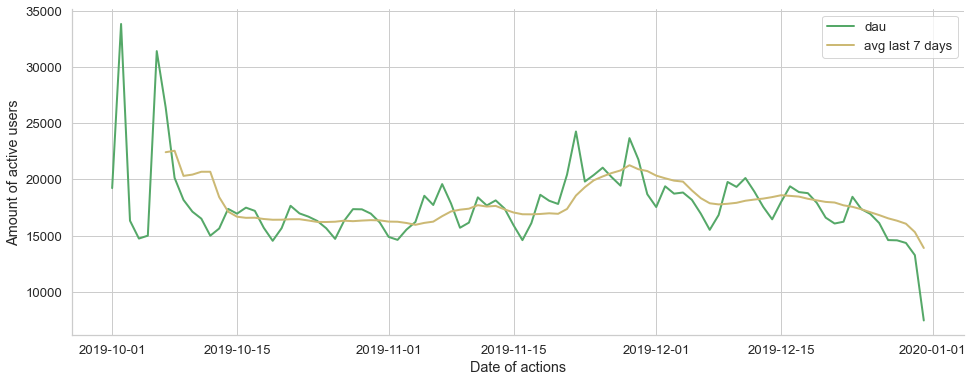

In [9]:
p = sns.lineplot(data=day_df.melt(['day']), x="day", y="value", hue='variable', palette=['g', 'y'], linewidth=2)
plt.legend(title='', labels=['dau', 'avg last 7 days'])
p.set_xlabel('Date of actions')
p.set_ylabel('Amount of active users')
sns.despine()
plt.show(p)

In [10]:
week_df = event_df.groupby('week_start_day', as_index=False).agg(wau=('user_id', 'nunique'))
display(week_df.head())
f"Mean wau: {round(week_df.wau.mean(), 2)}"

,week_start_day,wau
0,2019-09-30,115609
1,2019-10-07,107447
2,2019-10-14,94566
3,2019-10-21,93691
4,2019-10-28,92658


'Mean wau: 96477.07'

In [11]:
month_df = event_df.groupby('month_start_day', as_index=False).agg(mau=('user_id', 'nunique'))
display(month_df)
f"Mean mau: {round(month_df.mau.mean(), 2)}"

,month_start_day,mau
0,2019-10-01,399662
1,2019-11-01,368231
2,2019-12-01,370154


'Mean mau: 379349.0'

### 2.2 Conversion Rate

In [12]:
all_users = event_df.user_id.nunique()
purchase_users = event_df.query("event_type == 'purchase'").user_id.nunique()
abs_conv_to_purchase = purchase_users / all_users
f'Absolute conversion to purchase: {"{:.3%}".format(abs_conv_to_purchase)}'

'Absolute conversion to purchase: 7.133%'

In [13]:
cart_users = event_df.query("event_type == 'cart'").user_id.nunique()
rel_conv_to_purchase = purchase_users / cart_users
f'Conversion to purchase in relation to "cart" action: {"{:.3%}".format(rel_conv_to_purchase)}'

'Conversion to purchase in relation to "cart" action: 26.623%'

### 2.3 ARPU and ARPPU

In [14]:
period_rev = event_df.price.sum()

In [15]:
arpu = period_rev / all_users
f'ARPU: {"{:.2f}".format(arpu)} $'

'ARPU: 99.57 $'

In [16]:
arppu = period_rev / purchase_users
f'ARPPU: {"{:.2f}".format(arppu)} $'

'ARPPU: 1395.92 $'

### 2.4 Retention rate

#### 2.4.1 All peroid retention

In [17]:
days_subset = event_df[['day', 'user_id']]
user_min_day = days_subset.groupby('user_id', as_index=False).agg(birth_day=('day', 'min'))
days_subset = days_subset.merge(user_min_day, on='user_id')
days_subset['day_diff'] = days_subset.day - days_subset.birth_day

In [18]:
retention_form = days_subset.groupby('day_diff', as_index=False).agg(uniq_users=('user_id', 'nunique'))

In [19]:
zero_day = retention_form.uniq_users.max()
retention_form.uniq_users = 100 * retention_form.uniq_users / zero_day
retention_form.head()

,day_diff,uniq_users
0,0 days,100.000000
1,1 days,6.282702
2,2 days,3.262727
3,3 days,2.537336
4,4 days,2.149902


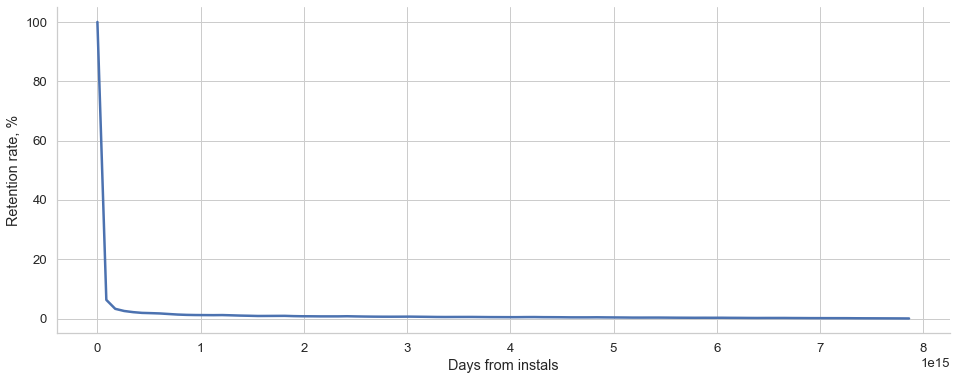

In [20]:
r = sns.lineplot(data=retention_form, x="day_diff", y="uniq_users", palette=['red'], linewidth=2.5)
r.set_xlabel('Days from instals')
r.set_ylabel('Retention rate, %')
sns.despine()

#### 2.4.2 Cohort Retention (weekly)

In [21]:
week_subset = event_df[['week_start_day', 'user_id']]
# Find birth week of each user
user_min_week = week_subset.groupby('user_id', as_index=False).agg(birth_week=('week_start_day', 'min'))
# Merge it with week_subset 
week_subset = week_subset.merge(user_min_week, on='user_id')
# Count difference between days and convert it to num of weeks
week_subset['week_diff'] = (week_subset.week_start_day - week_subset.birth_week) / np.timedelta64(1, 'W')

`birth_week` is cohort _(y)_, `week_diff` is distance _(x)_, count uniq users in pairs

In [22]:
cohort_retention = week_subset.groupby(['birth_week', 'week_diff'], as_index=False) \
                              .agg(uniq_users=('user_id', 'nunique')).sort_values(['birth_week', 'week_diff'])

Convert `uniq_users` to percentage values

In [23]:
# For each cohort take first distance ('week_diff == 0')
cohorts_first_week = cohort_retention.query('week_diff == 0')[['birth_week', 'uniq_users']] \
                                     .rename(columns={'uniq_users': 'first_uniq_users'})
# And merge it with main df
cohort_retention = cohort_retention.merge(cohorts_first_week, on='birth_week')

In [24]:
# Use two columns to calculate percentage
cohort_retention['uniq_users'] = 100 * (cohort_retention.uniq_users / cohort_retention.first_uniq_users)
# Drop useless first distance column
cohort_retention = cohort_retention.drop(columns = ['first_uniq_users'])
# Rename columns
cohort_retention = cohort_retention.rename(columns={'birth_week': 'cohort', \
                                                    'week_diff': 'cohort_period', 'uniq_users': 'users_percent'})

In [25]:
cohort_retention.head()

,cohort,cohort_period,users_percent
0,2019-09-30,0.0,100.000000
1,2019-09-30,1.0,11.211065
2,2019-09-30,2.0,8.091066
3,2019-09-30,3.0,6.848083
4,2019-09-30,4.0,6.163880


Great. Turn DF to pivot table

In [26]:
week_rr_result = cohort_retention.pivot(index='cohort', columns='cohort_period', values='users_percent')

Let's make some visualization magic

In [27]:
week_rr_result.index = week_rr_result.index.strftime('%Y-%m-%d')

In [28]:
week_rr_result.style \
              .set_caption('User weekly retention by cohort') \
              .background_gradient(cmap='RdPu') \
              .highlight_null('white') \
              .format("{:.2f}", na_rep="")

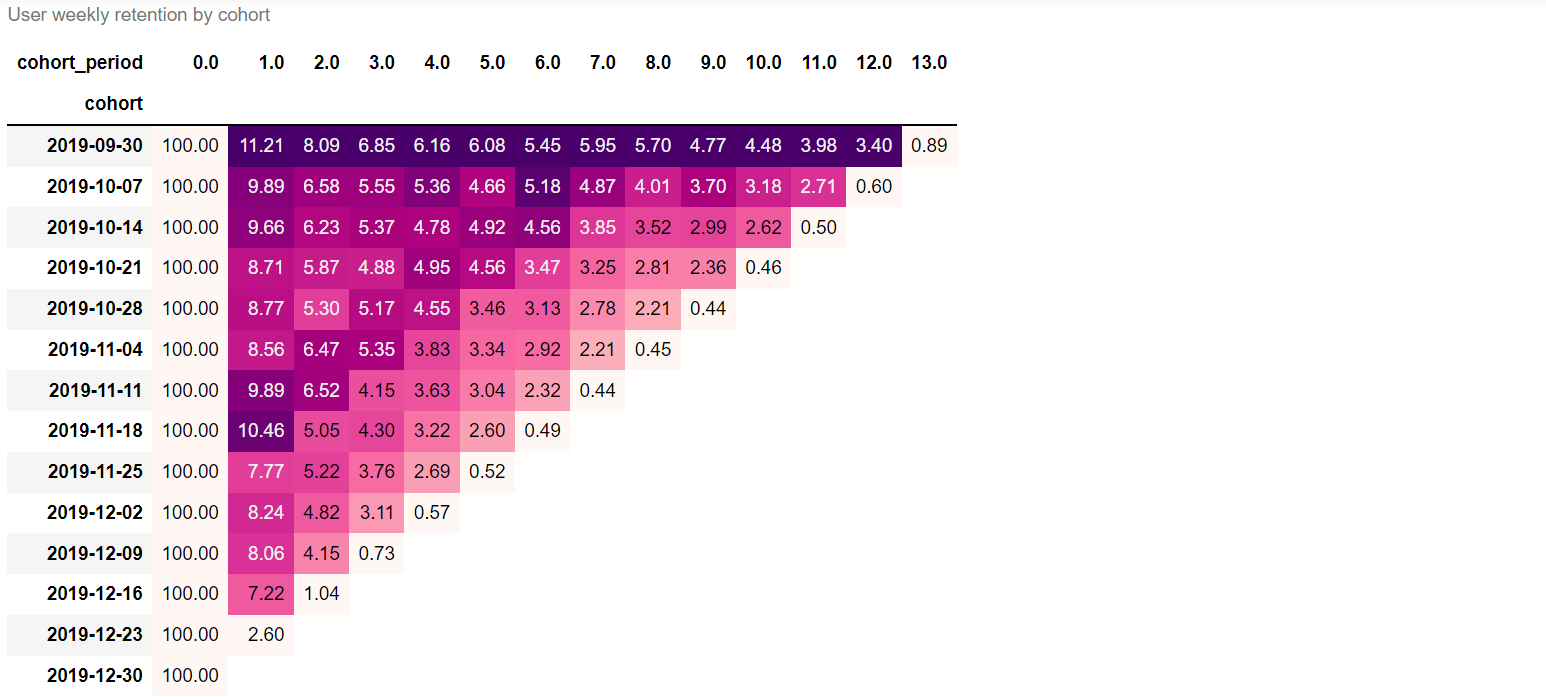

## 3. Visualization

### 3.1 Events lineplot

In [29]:
type_day_counter = event_df.groupby(['day', 'event_type'], as_index=False).agg(event_count=('event_time', 'count'))

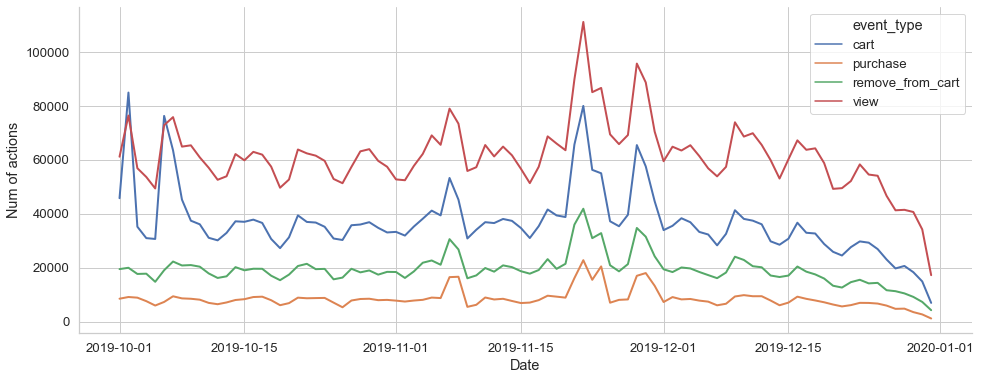

In [30]:
p1 = sns.lineplot(data=type_day_counter, x="day", y="event_count", hue='event_type', linewidth=2.0)
p1.set_xlabel('Date')
p1.set_ylabel('Num of actions')
sns.despine()

There are two anomalies in the first half of Septepber. If action chain _view -> cart -> (remove_from_cart) -> purchase_, situation when _cart > view_ is impossible.

### 3.2 Top-20 brands (by sales)

In [31]:
purchases_with_brands = event_df[(event_df.event_type == 'purchase') & (event_df.brand.notnull())]

In [32]:
brands_rate = purchases_with_brands.groupby('brand', as_index=False) \
                                   .agg(sales=('price', 'count')).sort_values(by='sales', ascending=False) \
                                   .reset_index(drop=True)
top_20 = brands_rate.head(20)
f'Total brands: {brands_rate.brand.nunique()}'

'Total brands: 234'

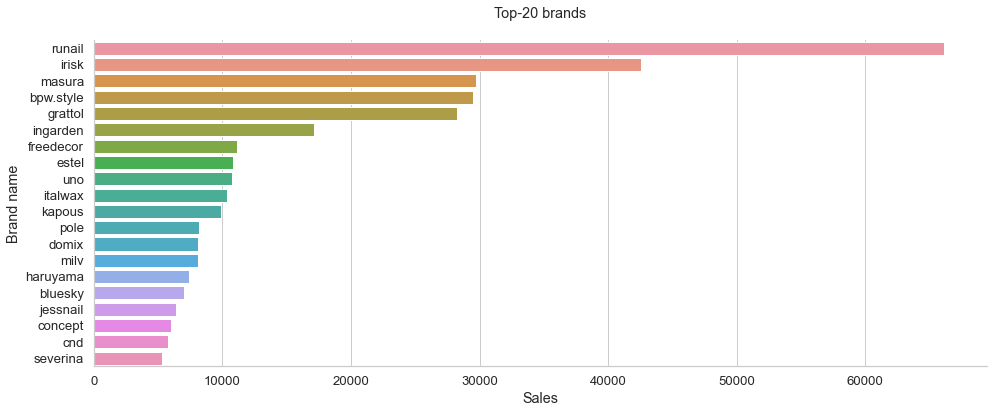

In [33]:
p2 = sns.barplot(data=top_20, x='sales', y='brand', orient='h')
p2.set_title('Top-20 brands\n')
p2.set_xlabel('Sales')
p2.set_ylabel('Brand name')
sns.despine()

In [34]:
brand_name = top_20.brand.values
brand_subset = purchases_with_brands.query('brand in @brand_name')

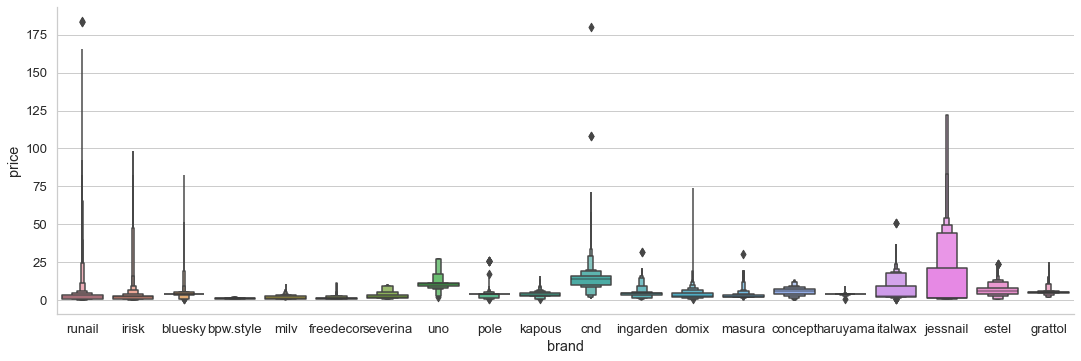

In [35]:
sns.catplot(x='brand', y='price', data=brand_subset, kind='boxen', height=5, aspect=3)
p2.set_xlabel('Brand')
p2.set_ylabel('Price')
sns.despine()

### 3.3 CR from cart to purchase

In [36]:
type_week_counter = event_df.groupby(['week_start_day', 'event_type'], as_index=False).agg(event_count=('event_time', 'count'))

In [37]:
pre_conv = type_week_counter.query("(event_type == 'purchase') | (event_type == 'cart')") \
                             .pivot(index='week_start_day', columns='event_type', values='event_count') \
                             .reset_index()
pre_conv['conv'] = pre_conv.purchase / pre_conv.cart * 100
week_conversion = pre_conv.drop(columns=['cart', 'purchase'])

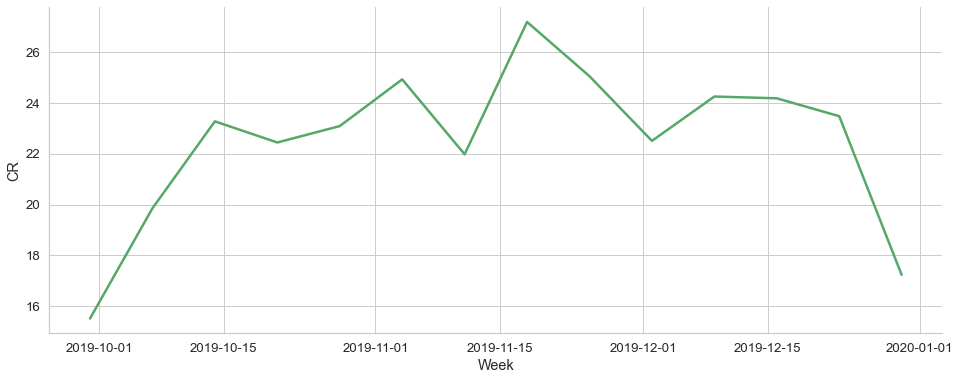

In [38]:
p3 = sns.lineplot(data=week_conversion, x="week_start_day", y="conv", color='g', linewidth=2.5)
p3.set_xlabel('Week')
p3.set_ylabel('CR')
sns.despine()
plt.show(p3)